In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import json
from sklearn.metrics import ndcg_score

In [3]:
# load the challenge set and anwers, but shorten track list to just be the IDS

def load_challenge_set_answers():
    f = open('challenge_set_answers.json')
    js = f.read()
    f.close()
    ans = json.loads(js)
    for playlist in ans['playlists']:
        playlist['tracks'] = list(map(lambda x: x['track_uri'][14:], playlist['tracks']))
    return ans

def load_challenge_set():
    f = open('challenge_set.json')
    js = f.read()
    f.close()
    challenge_set = json.loads(js)
    for playlist in challenge_set['playlists']:
        playlist['tracks'] = list(map(lambda x: x['track_uri'][14:], playlist['tracks']))
    return challenge_set

challenge_set_answers = load_challenge_set_answers()
challenge_set = load_challenge_set()

In [4]:
def get_ndcg_score(actual, preds):
    # construct stuff necessary for ndcg_score
    all_tracks = list(set(actual + preds))
    
    track_to_idx = {}
    for i, track in enumerate(all_tracks):
        track_to_idx[track] = i
    n_tracks = len(all_tracks)

    real_songs = np.zeros((1, n_tracks))
    pred_songs = np.zeros((1, n_tracks))

    # label tracks in the actual set with 1
    for track in actual:
        real_songs[0, track_to_idx[track]] = 1 

    # label tracks in predicted set with rank
    for i, track in enumerate(preds):
        if track in track_to_idx:
            pred_songs[0, track_to_idx[track]] = len(preds) - i

    return ndcg_score(real_songs, pred_songs, k=len(preds))

# click is defined as # of times to refresh 10 tracks until you find a relevant one
def get_clicks(actual, preds):
    i = 0
    for track in preds:
        if track in actual:
            return i // 10
        i += 1
    return -1

def get_r_precision(actual, preds):
    actual = set(actual)
    preds = set(preds)
    return len(actual.intersection(preds)) / len(actual)

def get_mrr(actual, preds):
    for i, track in enumerate(preds):
        if track in actual:
            return 1 / (i + 1)
    return 0


def get_submission_stats(preds):
    '''
    Preds is a list of lists, where each inner list has the predicted tracks for a playlist

    Returns a tuple list, (ndcg, clicks, precision, mrr)
    '''
    out = []
    for i in range(len(preds)):
        actual = challenge_set_answers['playlists'][i]['tracks']
        inner_preds = preds[i]
        ndcg = get_ndcg_score(actual, inner_preds)
        clicks = get_clicks(actual, inner_preds)
        precision = get_r_precision(actual, inner_preds)
        mrr = get_mrr(actual, inner_preds)
        out.append((ndcg, clicks, precision, mrr))
    return out

In [5]:
def get_performance_results(submission_file):  
    '''
    This function will take a CSV file, (submission file)
    and return the results how well the model performed on
    the challenge set.

    The first column of the CSV file should be the playlist id, 
    which will be dropped. The rest should all be spotify
    track URIs. Each line should contain 500 URIs.
    ''' 
    fp = open(submission_file, 'r')
    preds = []
    spotify_flag = False
    for line in fp:

        # lines start with their index, and are split by ', '
        # also, some submissions have the spotify URI prefix, some dont. check for that
        # (i was dumb and did not standardize this)
        no_first = line.split(', ')[1:]
        if no_first[0].startswith("spotify:"):
            spotify_flag = True

        if spotify_flag:
            preds.append(list(map(lambda x: x[14:], no_first)))
        else:
            preds.append(no_first)

    fp.close()

    stats = get_submission_stats(preds)
    results = []

    # get the stats for each playlist
    for i, row in enumerate(preds):
        playlist = challenge_set_answers['playlists'][i]

        ndcg, clicks, precision, mrr = stats[i]
        results.append({
            "num_holdouts": playlist['num_holdouts'],
            "num_samples": playlist['num_samples'],
            "num_tracks": playlist['num_tracks'],
            "playlist_name": playlist['name'],
            "includes_name": challenge_set['playlists'][i]['name'] != "",
            "random": playlist['random'],
            "ndcg": ndcg,
            "clicks": clicks,
            "precision": precision,
            "mrr": mrr,
        })
        
    return results

In [6]:
def partition_results(results):
    '''
    Take a "results" object (from the get_performance_results function)
    and extract meaningful data from it

    Challenge set data rules are included for reference:

    (1) title only (2) title and the first track (3) title and the first 
    five tracks (4) the first five tracks (no title) 
    (5) title and the first 10 tracks (6) the first 10 tracks (no title) 
    (7) title and the first 25 tracks (8) title and 25 random tracks
    (9) title and the first 100 tracks (10) title and 100 random tracks. A
    final submission for this challenge should contain 500 tracks for
    each of the test playlists, ordered by relevance.
    '''
    # divide the playlists into buckets according to the challenge rules
    buckets = [[] for i in range(10)]
    averages = [{'ndcg': [], 'clicks': [], 'precision': [], 'mrr': []} for i in range(10)]

    for res in results:
        bucket = 0
        if res['num_samples'] == 0:
            # title only
            bucket = 9
        elif res['num_samples'] == 1:
            # title and the first track
            bucket = 8
        elif res['num_samples'] == 5:
            if res['includes_name']:
                # title and the first five tracks
                bucket = 7
            else:
                # the first five tracks (no title)
                bucket = 6
        elif res['num_samples'] == 10:
            if res['includes_name']:
                # title and the first 10 tracks
                bucket = 5
            else:
                # the first 10 tracks (no title)
                bucket = 4
        elif res['num_samples'] == 25:
            if not res['random']:
                bucket = 3
            else:
                # title and 25 random tracks
                bucket = 2
        elif res['num_samples'] == 100:
            if not res['random']:
                # title and the first 100 tracks
                bucket = 1
            # title and 100 random tracks
            # bucket is 0 by default

        # add to proper buckets
        buckets[bucket].append(res)
        averages[bucket]['ndcg'].append(res['ndcg'])
        if res['clicks'] != -1:
            # clicks is -1 if no relevant tracks were found
            averages[bucket]['clicks'].append(res['clicks'])
        averages[bucket]['precision'].append(res['precision'])
        averages[bucket]['mrr'].append(res['mrr'])

    for i in range(10):
        averages[i]['ndcg'] = np.mean(averages[i]['ndcg'])
        averages[i]['clicks'] = np.mean(averages[i]['clicks'])
        averages[i]['precision'] = np.mean(averages[i]['precision'])
        averages[i]['mrr'] = np.mean(averages[i]['mrr'])
    return averages, buckets

In [19]:
def display_results(submission_file):
    '''
    Do the heavy lifting of calling previous functions.

    This function will take a csv file with the same format as submission.hdf
    and display the results in a table.
    '''
    averages, buckets = partition_results(get_performance_results(submission_file))

    table = pd.DataFrame(averages)
    table.index = ['title only', 'title & first track', 
                'title & first five tracks', 'first five tracks (no title)', 
                'title & first 10 tracks', 'first 10 tracks (no title)', 
                'title & first 25 tracks', 'title & 25 random tracks', 
                'title & first 100 tracks', 'title & 100 random tracks']
    table.columns = ['NDCG', 'Clicks', 'Precision', 'MRR']

    return table

print("Original submission results:")
display(display_results('submission.hdf'))
print("frequency submission results:")
display(display_results('frequency_submission.hdf'))
print("Item-item submission results:")
display(display_results('item_item_submission.hdf'))

Original submission results:


,NDCG,Clicks,Precision,MRR
title only,0.067113,6.376812,0.089944,0.120775
title & first track,0.130603,5.119048,0.226999,0.127983
title & first five tracks,0.085338,6.146667,0.147664,0.092849
first five tracks (no title),0.124363,8.086420,0.269378,0.097327
title & first 10 tracks,0.069108,11.056604,0.199896,0.031203
first 10 tracks (no title),0.097471,8.506849,0.194277,0.052831
title & first 25 tracks,0.097277,8.483871,0.184384,0.084468
title & 25 random tracks,0.097085,7.907692,0.158318,0.113306
title & first 100 tracks,0.055211,9.843137,0.094122,0.042153
title & 100 random tracks,0.024942,12.160000,0.049888,0.016402


frequency submission results:


,NDCG,Clicks,Precision,MRR
title only,0.133267,2.773810,0.176938,0.288320
title & first track,0.094223,2.567901,0.134530,0.198263
title & first five tracks,0.190960,1.564706,0.253708,0.360402
first five tracks (no title),0.108934,3.430556,0.165266,0.173350
title & first 10 tracks,0.125791,3.206349,0.205768,0.182208
first 10 tracks (no title),0.139220,2.212500,0.180727,0.254980
title & first 25 tracks,0.138944,3.426829,0.188442,0.291658
title & 25 random tracks,0.140187,2.283951,0.177669,0.304359
title & first 100 tracks,0.130290,2.328947,0.151117,0.312492
title & 100 random tracks,0.073664,10.789474,0.130731,0.061818


Item-item submission results:


/Users/peterolsen/.pyenv/versions/csci5123-proj/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/peterolsen/.pyenv/versions/csci5123-proj/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,NDCG,Clicks,Precision,MRR
title only,0.031136,185.500000,0.000247,0.000011
title & first track,0.027134,NaN,0.000000,0.000000
title & first five tracks,0.039697,181.000000,0.000417,0.000006
first five tracks (no title),0.047423,101.000000,0.000680,0.000061
title & first 10 tracks,0.047854,4.000000,0.000263,0.000222
first 10 tracks (no title),0.035151,NaN,0.000000,0.000000
title & first 25 tracks,0.043773,36.500000,0.000633,0.000084
title & 25 random tracks,0.033670,105.666667,0.000630,0.000029
title & first 100 tracks,0.025454,87.000000,0.000241,0.000024
title & 100 random tracks,0.023958,129.000000,0.000167,0.000008


/Users/peterolsen/.pyenv/versions/csci5123-proj/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/peterolsen/.pyenv/versions/csci5123-proj/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


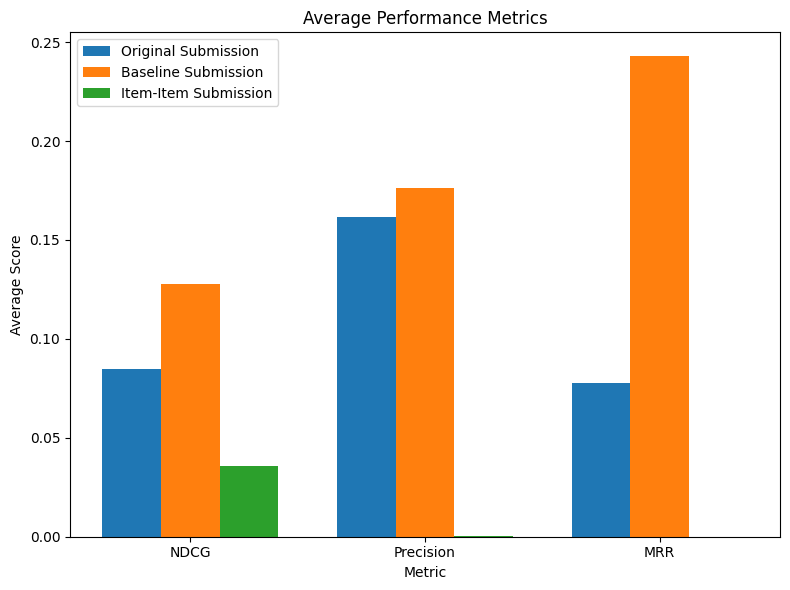

In [ ]:
import matplotlib.pyplot as plt

submission = display_results('submission.hdf')
frequency_submission = display_results('frequency_submission.hdf')
item_item_submission = display_results('item_item_submission.hdf')

submission_averages = submission.mean(axis=0).drop(['Clicks'])
frequency_averages = frequency_submission.mean(axis=0).drop(['Clicks'])
item_item_averages = item_item_submission.mean(axis=0).drop(['Clicks'])

metrics = ['NDCG', 'Precision', 'MRR']
x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(8, 6))
plt.bar(x - width, submission_averages, width, label='Original Submission')
plt.bar(x, frequency_averages, width, label='frequency Submission')
plt.bar(x + width, item_item_averages, width, label='Item-Item Submission')

plt.title('Average Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Average Score')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()